# Spoint tutorial: Deconvolution of cell types composition on human brain Visium dataset

July 2023

Dataset: Visium slices of human dorsolateral prefrontal cortex ([here](https://zenodo.org/record/8135478)).

In [1]:
from SPACEL.setting import set_environ_seed, auto_cuda_device
set_environ_seed(), auto_cuda_device()
from SPACEL import Spoint
import scanpy as sc
import numpy as np
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.serif'] = ['Arial']
sc.settings.set_figure_params(dpi=50,dpi_save=300,facecolor='white',fontsize=10,vector_friendly=True,figsize=(3,3))
sc.settings.verbosity = 3

Setting environment seed: 42
Using GPU: 0


## Load spatial transcriptomics data

The input data are anndata objects stored raw counts for scRNA-seq and ST. The scRNA-seq anndata must have cell type annotation in `.obs`.

In [2]:
sc_ad = sc.read_h5ad('../data/visium_human_DLPFC/human_MTG_snrna_norm_by_exon.h5ad')
st_ad = sc.read_h5ad('../data/visium_human_DLPFC/human_DLPFC_spatial_151676.h5ad')

sc.pp.filter_genes(st_ad,min_cells=1)
sc.pp.filter_genes(sc_ad,min_cells=1)
sc.pp.filter_cells(st_ad,min_genes=1)
sc.pp.filter_cells(sc_ad,min_genes=1)

filtered out 12226 genes that are detected in less than 1 cells
filtered out 32 genes that are detected in less than 1 cells


## Initialize the Spoint model

In this step, we initialize the Spoint model using anndata objects for scRNA-seq and ST as input. The `celltype_key` parameter represents the column name of the cell type annotation in the `.obs` attribute of the scRNA-seq anndata object. The `sm_size` parameter controls the number of simulated spots, and it is important to have a sufficient `sm_size` for accurate prediction. However, it should be noted that increasing the `sm_size` will also increase the simulation and training time. In general, we recommend setting `sm_size` to a value greater than 100,000.

In [3]:
spoint = Spoint.init_model(sc_ad,st_ad,celltype_key='cluster_label',deg_method='t-test',sm_size=100000,use_gpu=True)

Setting global seed: 42
normalizing counts per cell
    finished (0:00:02)
normalizing counts per cell
    finished (0:00:00)
### Finding marker genes...
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:05:11)
cluster_label
Astro L1 FGFR3 FOS          200
Exc L6 FEZF2 VWA2           200
Inh L1-6 VIP PENK           200
Inh L1-6 PVALB SCUBE3       200
Inh L1-6 LAMP5 CA13         200
                           ... 
Inh L6 SST NPY              124
Inh L1 ADARB2 DISP2         109
Inh L1-2 PVALB TAC1          91
VLMC L1-3 CYP1B1             38
Inh L6 LAMP5 ANKRD20A11P     28
Name: count, Length: 120, dtype: int64
### Used gene numbers: 5137
### Initializing sample proba

## Training the Spoint model

Here, we train the model to obtain the optimal model for cell type deconvolution. The `max_steps` parameter represents the maximum number of steps in the training process. If the `early_stop` parameter is set to `True`, the model will stop training before reaching the maximum number of steps if the model has converged.

In [4]:
spoint.train(max_steps=5000, batch_size=1024)

Epoch 100/100: 100%|██████████| 100/100 [07:03<00:00,  4.17s/it, loss=1.64e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [07:03<00:00,  4.24s/it, loss=1.64e+03, v_num=1]


Step 5000: Test inference loss=-0.557: 100%|██████████| 5000/5000 [3:18:22<00:00,  2.38s/it]  


## Visualization results

Then, we utilize the trained model to predict the cell type composition of each spot in the spatial transcriptomics data. This prediction will generate a `DataFrame` object, where each row corresponds to a spot in the spatial transcriptomics data, each column represents a cell type from the single-cell RNA-seq data, and each entry indicates the proportion of a particular cell type in a spot. Additionally, we can obtain the anndata object of the spatial transcriptomics data with the deconvolution results embedded in the `.obs` attribute.

In [5]:
pre = spoint.deconv_spatial()

In [6]:
st_ad = spoint.st_ad

We can see the result of deconvolution in the ST slice.

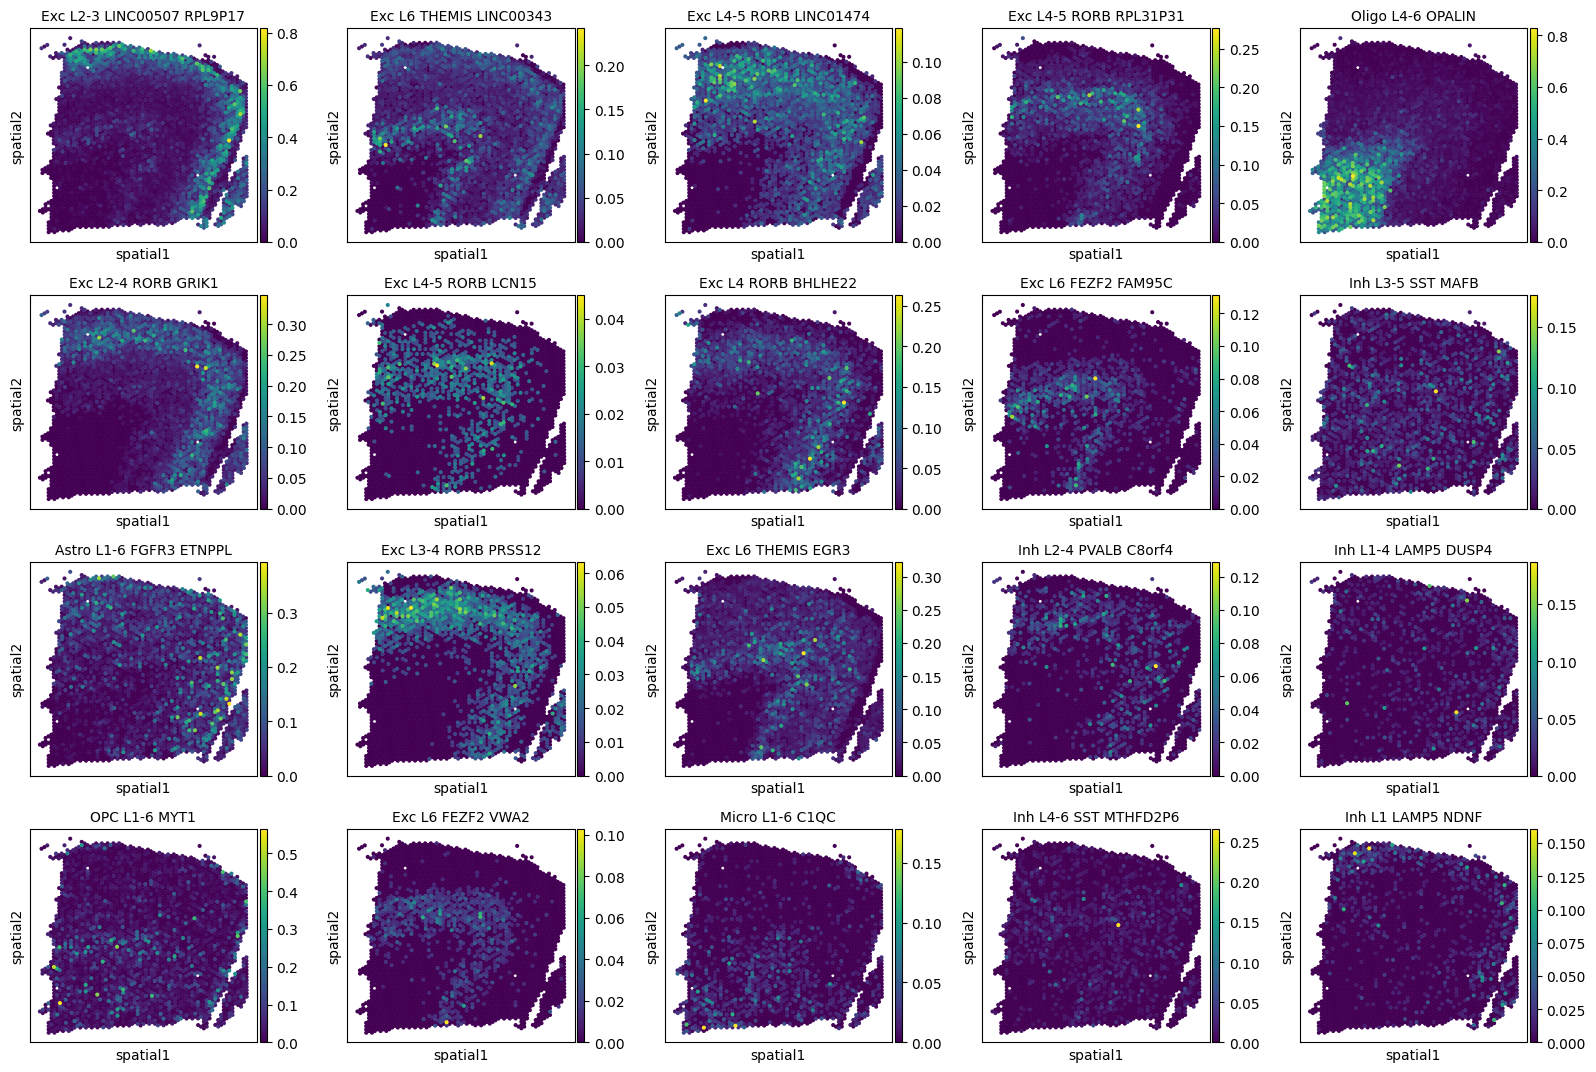

In [7]:
sc.pl.embedding(st_ad,color=pre.columns[:20],basis='spatial',ncols=5)